In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick   
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as sk_auc
import sys, os
sys.path.append(os.path.abspath('..'))
from ift6758.data.feature_engineering_one import feature_engineering_one
from ift6758.data.feature_engineering_pt2 import feature_engineering_two
import ift6758.data.advanced_models as adv

In [11]:
def compute_auc_roc(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = sk_auc(fpr, tpr)
    print(f"AUC: {roc_auc:.3f}")
    return fpr, tpr, roc_auc

In [12]:
# Percentiles of predicted probabilities
def goal_rate_vs_percentile(y_test, y_pred_proba):
    df_val_percentile = pd.DataFrame({
        'y_true': y_test,
        'y_prob': y_pred_proba
    })

    # Sort highest probability first
    df_val_percentile = df_val_percentile.sort_values(by='y_prob', ascending=False)

    # Assign percentile rank (0 to 100), reversed correctly
    df_val_percentile['percentile'] = np.linspace(100, 0, len(df_val_percentile))

    # Bin into percentiles (e.g., 100 bins)
    df_val_percentile['percentile_bin'] = pd.qcut(df_val_percentile['percentile'], q=100, labels=False)

    # Compute goal rate per percentile
    goal_rate = df_val_percentile.groupby('percentile_bin')['y_true'].mean()
    return goal_rate.index, goal_rate.values

In [13]:
#Cumulative proportion of goals 
def cumulative_goal_curve(y_test, y_pred_proba):
    # DataFrame with true labels + predicted probabilities
    df_val_cum = pd.DataFrame({
        'y_true': y_test,
        'y_prob': y_pred_proba
    })

    # 1. Sort by predicted probability (highest → lowest)
    df_val_cum = df_val_cum.sort_values(by='y_prob', ascending=False).reset_index(drop=True)

    # 2. Compute cumulative number of GOALS encountered as we move down the list
    df_val_cum['cumulative_goals'] = df_val_cum['y_true'].cumsum()

    # 3. Convert cumulative goals to a proportion (%) of all goals
    total_goals = df_val_cum['y_true'].sum()
    df_val_cum['cumulative_goal_percent'] = (df_val_cum['cumulative_goals'] / total_goals) * 100

    # 4. Create percentile axis (100 → 0)
    df_val_cum['percentile'] = np.linspace(100, 0, len(df_val_cum))
    return df_val_cum

In [18]:
df_eng_one = feature_engineering_one(years=range(2020, 2021))

100%|██████████| 952/952 [00:52<00:00, 18.27it/s]


In [19]:
# Load your test set
df_eng_one["game_id"] = df_eng_one["game_id"].astype(str)

# Regular season → ends with "02"
df_eng_one_regular = df_eng_one[df_eng_one["game_id"].str.endswith("02")].copy()

# Playoff season → ends with "03"
df_eng_one_playoff = df_eng_one[df_eng_one["game_id"].str.endswith("03")].copy()

y_test_eng_one_regular = df_eng_one_regular['is_goal']
X_test_eng_one_regular = df_eng_one_regular.drop(columns=['is_goal'])
numerical_cols = X_test_eng_one_regular.select_dtypes(include=['number']).columns
median_values = X_test_eng_one_regular[numerical_cols].median()
X_test_eng_one_regular[numerical_cols] = X_test_eng_one_regular[numerical_cols].fillna(median_values)

y_test_eng_one_playoff = df_eng_one_playoff['is_goal']
X_test_eng_one_playoff = df_eng_one_playoff.drop(columns=['is_goal'])
numerical_cols = X_test_eng_one_playoff.select_dtypes(include=['number']).columns
median_values = X_test_eng_one_playoff[numerical_cols].median()
X_test_eng_one_playoff[numerical_cols] = X_test_eng_one_playoff[numerical_cols].fillna(median_values)

In [20]:
df = feature_engineering_two(years=range(2016, 2021))

100%|██████████| 6150/6150 [06:52<00:00, 14.90it/s]


In [43]:
# Load your test set

df_train_val = df[df['season'] < 20202021]
df_eng_two = df[df['season'] == 20202021]
df_eng_two["game_id"] = df_eng_two["game_id"].astype(str)

# Regular season → ends with "02"
df_eng_two_regular = df_eng_two[df_eng_two["game_id"].str.endswith("02")].copy().reset_index()

# Playoff season → ends with "03"
df_eng_two_playoff = df_eng_two[df_eng_two["game_id"].str.endswith("03")].copy().reset_index()

y_test_eng_two_regular = df_eng_two_regular['is_goal']
X_test_eng_two_regular = df_eng_two_regular.drop(columns=['is_goal'])

y_test_eng_two_playoff = df_eng_two_playoff['is_goal']
X_test_eng_two_playoff = df_eng_two_playoff.drop(columns=['is_goal'])

C:\Users\aniss\AppData\Local\Temp\ipykernel_30524\3533178279.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng_two["game_id"] = df_eng_two["game_id"].astype(str)


In [36]:
X_test_eng_two_regular.columns

Index(['index', 'game_id', 'season', 'game_time', 'period', 'period_time',
       'event_type', 'team_id', 'team_name', 'coordinates_x', 'coordinates_y',
       'shooter', 'goalie', 'shot_type', 'empty_net', 'strength',
       'situation_code', 'previous_event_name', 'previous_event_x',
       'previous_event_y', 'previous_event_timeperiod', 'isHomeTeam',
       'friendly_skaters', 'opponent_skaters', 'zone_code',
       'current_event_timeseconds', 'previous_event_timeseconds',
       'time_since_last_event', 'rebound', 'distance_from_last_event',
       'angle_shot_prev', 'angle_shot', 'speed', 'angle_change',
       'distance_shot', 'game_seconds_true'],
      dtype='object')

In [ ]:
def adjustments(df2):
    X = df2[['game_time', 'period','period_time', 'coordinates_x','coordinates_y',
            'distance_shot', 'angle_shot','shot_type','previous_event_name',
            'previous_event_timeperiod','friendly_skaters','opponent_skaters','previous_event_timeseconds',
            'previous_event_x','previous_event_y','distance_from_last_event', 'time_since_last_event',
            'rebound','angle_change','speed']]
        
    X = X.copy()
    X['rebound'] = X['rebound'].astype(int)
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns
    median_values = X[numerical_cols].median()
    X.loc[:, numerical_cols] = X[numerical_cols].fillna(median_values)
    X.loc[:, categorical_cols] = X[categorical_cols].fillna('Unknown')
    X = adv._calculate_time_second(X)
    X = adv._calculate_period_second(X)
    X = X.drop(columns=['game_time', 'period_time', 'previous_event_timeperiod'])
    return X

X_test_eng_two_regular = adjustments(X_test_eng_two_regular)
X_test_eng_two_playoff = adjustments(X_test_eng_two_playoff)
y_train_val = df_train_val['is_goal']
X_train_val = df_train_val.drop(columns=['is_goal'])
X_train_val = adjustments(X_train_val)

In [49]:
# def transformation(X_train_val, X_test, y_train_val):   
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)
exclude_cols = ['shot_type', 'previous_event_name','rebound']
num_cols = [
    col for col in X_train2.columns
    if col not in exclude_cols and X_train2[col].dtype in ['float64', 'int64']
]
scaler = StandardScaler()
X_train2[num_cols] = scaler.fit_transform(X_train2[num_cols])
X_test_eng_two_regular[num_cols] = scaler.transform(X_test_eng_two_regular[num_cols])
X_test_eng_two_playoff[num_cols] = scaler.transform(X_test_eng_two_playoff[num_cols])
X_train2, ohe = adv.change_to_one_hot(X_train2, ['shot_type', 'previous_event_name'], ohe=None)
X_test_eng_two_regular, _ = adv.change_to_one_hot(X_test_eng_two_regular, ['shot_type', 'previous_event_name'], ohe=ohe)
X_test_eng_two_playoff, _ = adv.change_to_one_hot(X_test_eng_two_playoff, ['shot_type', 'previous_event_name'], ohe=ohe)

In [50]:
import wandb
import joblib
import pandas as pd
from sklearn.metrics import roc_auc_score

# Initialize W&B API
api = wandb.Api()

# List of saved model artifact names (must match your W&B artifact names)
artifact_names = [
    "model1-distance",
    "model2-angle",
    "model3-distance-angle",
    "xgb_all_features",
    "gridsearch_best"   # if you saved that one
]

# Your W&B entity/project
ENTITY = "IFT6758-2025-B1"
PROJECT = "IFT6758-2025-B01"

models = {}

for name in artifact_names:
    full_name = f"{ENTITY}/{PROJECT}/{name}:latest"
    print(f"📥 Downloading {full_name} ...")

    artifact = api.artifact(full_name, type="model")
    artifact_dir = artifact.download()

    # 🔹 adjust this filename depending on what you logged
    model_path = f"{artifact_dir}/model.joblib"  # ← you saved it with this name
    model = joblib.load(model_path)

    models[name] = model


📥 Downloading IFT6758-2025-B1/IFT6758-2025-B01/model1-distance:latest ...


wandb:   1 of 1 files downloaded.  


📥 Downloading IFT6758-2025-B1/IFT6758-2025-B01/model2-angle:latest ...


wandb:   1 of 1 files downloaded.  


📥 Downloading IFT6758-2025-B1/IFT6758-2025-B01/model3-distance-angle:latest ...


wandb:   1 of 1 files downloaded.  


📥 Downloading IFT6758-2025-B1/IFT6758-2025-B01/xgb_all_features:latest ...


wandb:   1 of 1 files downloaded.  


📥 Downloading IFT6758-2025-B1/IFT6758-2025-B01/gridsearch_best:latest ...


wandb:   1 of 1 files downloaded.  


In [53]:
y_pred_proba_1_regular = models["model1-distance"].predict_proba(X_test_eng_one_regular[["distance_to_net"]])[:, 1]
y_pred_proba_2_regular = models["model2-angle"].predict_proba(X_test_eng_one_regular[["shot_angle"]])[:, 1]
y_pred_proba_3_regular = models["model3-distance-angle"].predict_proba(X_test_eng_one_regular[["distance_to_net", "shot_angle"]])[:, 1]
X_test_eng_two_regular_2 = X_test_eng_two_regular.drop(columns='time_since_last_event').copy()
y_pred_proba_4_regular = models["xgb_all_features"].predict_proba(X_test_eng_two_regular_2)[:, 1]
y_pred_proba_5_regular = models["gridsearch_best"].predict_proba(X_test_eng_two_regular)[:, 1]

y_pred_proba_1_playoff = models["model1-distance"].predict_proba(X_test_eng_one_playoff[["distance_to_net"]])[:, 1]
y_pred_proba_2_playoff = models["model2-angle"].predict_proba(X_test_eng_one_playoff[["shot_angle"]])[:, 1]
y_pred_proba_3_playoff = models["model3-distance-angle"].predict_proba(X_test_eng_one_playoff[["distance_to_net", "shot_angle"]])[:, 1]
X_test_eng_two_playoff_2 = X_test_eng_two_playoff.drop(columns='time_since_last_event').copy()
y_pred_proba_4_playoff = models["xgb_all_features"].predict_proba(X_test_eng_two_playoff_2)[:, 1]
y_pred_proba_5_playoff = models["gridsearch_best"].predict_proba(X_test_eng_two_playoff)[:, 1]

In [54]:
curves_regular = {}
for i, (y_pred, label, y_test) in enumerate([
    (y_pred_proba_1_regular, "Model 1 (Distance)", y_test_eng_one_regular),
    (y_pred_proba_2_regular, "Model 2 (Angle)", y_test_eng_one_regular),
    (y_pred_proba_3_regular, "Model 3 (Distance + Angle)", y_test_eng_one_regular),
    (y_pred_proba_4_regular, "Model 4 (XGBoost All Features)", y_test_eng_two_regular),
    (y_pred_proba_5_regular, "Model 5 (GridSearch All Features)", y_test_eng_two_regular)
]):
    fpr, tpr, auc = compute_auc_roc(y_test, y_pred)
    pctl, goal_rate = goal_rate_vs_percentile(y_test, y_pred)
    df_cum = cumulative_goal_curve(y_test, y_pred)
    curves_regular[label] = dict(fpr=fpr, tpr=tpr, auc=auc,
                         pctl=pctl, goal_rate=goal_rate,
                         df_cum=df_cum, preds=y_pred)
    print(f"{label}: AUC = {auc:.3f}")

AUC: 0.710
Model 1 (Distance): AUC = 0.710
AUC: 0.456
Model 2 (Angle): AUC = 0.456
AUC: 0.709
Model 3 (Distance + Angle): AUC = 0.709
AUC: 0.529
Model 4 (XGBoost All Features): AUC = 0.529
AUC: 0.551
Model 5 (GridSearch All Features): AUC = 0.551


In [55]:
curves_playoff = {}
for i, (y_pred, label, y_test) in enumerate([
    (y_pred_proba_1_playoff, "Model 1 (Distance)", y_test_eng_one_playoff),
    (y_pred_proba_2_playoff, "Model 2 (Angle)", y_test_eng_one_playoff),
    (y_pred_proba_3_playoff, "Model 3 (Distance + Angle)", y_test_eng_one_playoff),
    (y_pred_proba_4_playoff, "Model 4 (XGBoost All Features)", y_test_eng_two_playoff),
    (y_pred_proba_5_playoff, "Model 5 (GridSearch All Features)", y_test_eng_two_playoff)
]):
    fpr, tpr, auc = compute_auc_roc(y_test, y_pred)
    pctl, goal_rate = goal_rate_vs_percentile(y_test, y_pred)
    df_cum = cumulative_goal_curve(y_test, y_pred)
    curves_playoff[label] = dict(fpr=fpr, tpr=tpr, auc=auc,
                         pctl=pctl, goal_rate=goal_rate,
                         df_cum=df_cum, preds=y_pred)
    print(f"{label}: AUC = {auc:.3f}")

AUC: 0.654
Model 1 (Distance): AUC = 0.654
AUC: 0.486
Model 2 (Angle): AUC = 0.486
AUC: 0.654
Model 3 (Distance + Angle): AUC = 0.654
AUC: 0.510
Model 4 (XGBoost All Features): AUC = 0.510
AUC: 0.465
Model 5 (GridSearch All Features): AUC = 0.465


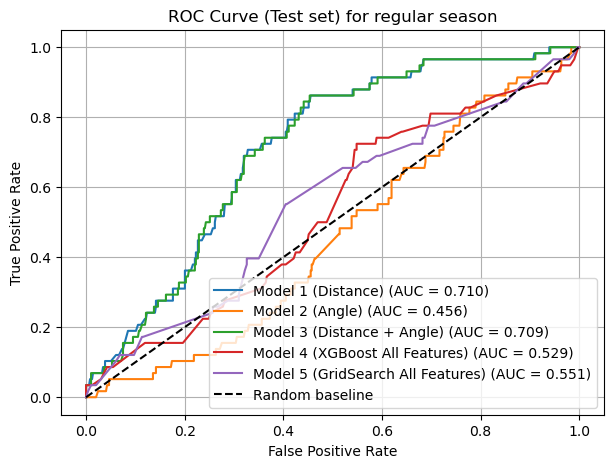

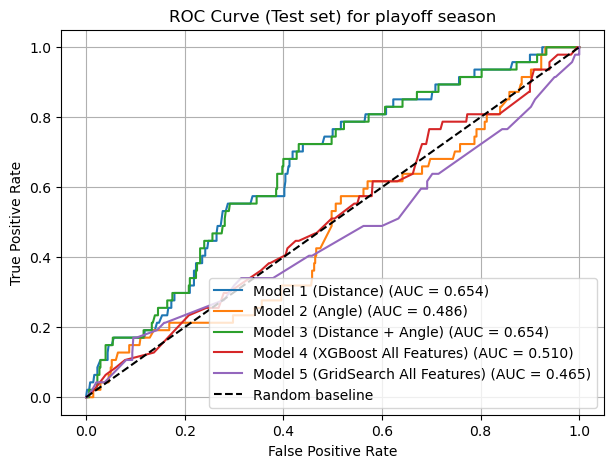

In [56]:
def plot_roc(curves, type):
    plt.figure(figsize=(7,5))
    for label, data in curves.items():
        plt.plot(data["fpr"], data["tpr"], label=f"{label} (AUC = {data['auc']:.3f})")
    plt.plot([0,1],[0,1],'k--', label='Random baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (Test set) for {type} season")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_roc(curves_regular, 'regular')
plot_roc(curves_playoff, 'playoff')

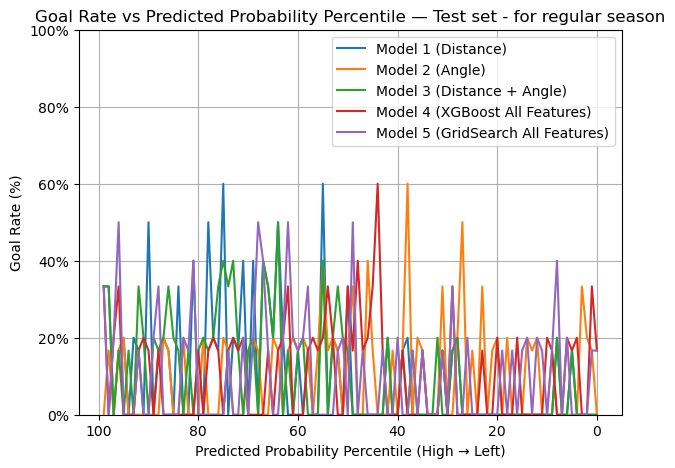

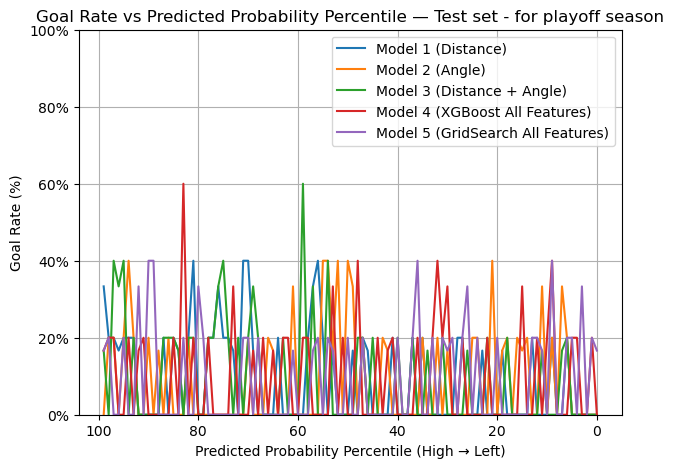

In [57]:
def plot_goal_rate(curves, type):
    plt.figure(figsize=(7,5))
    for label, data in curves.items():
        plt.plot(data["pctl"], data["goal_rate"]*100, label=label)
    plt.gca().invert_xaxis()
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.ylim(0,100)
    plt.xlabel("Predicted Probability Percentile (High → Left)")
    plt.ylabel("Goal Rate (%)")
    plt.title(f"Goal Rate vs Predicted Probability Percentile — Test set - for {type} season")
    plt.legend(); plt.grid(True); plt.show()
plot_goal_rate(curves_regular, 'regular')
plot_goal_rate(curves_playoff, 'playoff')

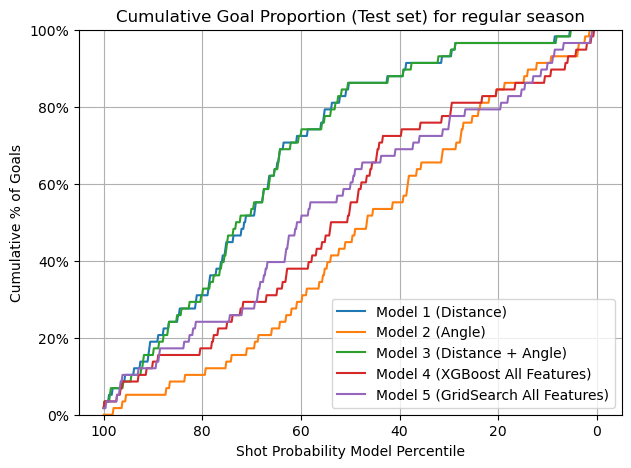

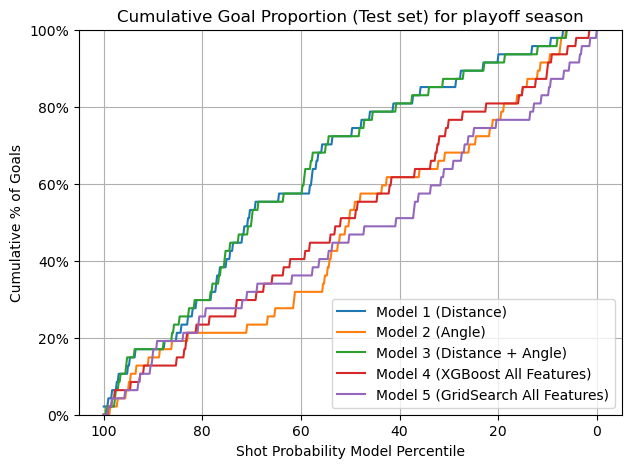

In [58]:
def plot_cummulative(curves, type) : 
    plt.figure(figsize=(7,5))
    for label, data in curves.items():
        plt.plot(data["df_cum"]["percentile"], data["df_cum"]["cumulative_goal_percent"], label=label)
    plt.gca().invert_xaxis()
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.ylim(0, 100)
    plt.xlabel("Shot Probability Model Percentile")
    plt.ylabel("Cumulative % of Goals")
    plt.title(f"Cumulative Goal Proportion (Test set) for {type} season")
    plt.legend(); plt.grid(True); plt.show()
plot_cummulative(curves_regular, 'regular')
plot_cummulative(curves_playoff, 'playoff')

In [59]:
# plt.figure(figsize=(7,5))

# # Model 1 (distance)
# CalibrationDisplay.from_predictions(
#     y_test,
#     y_pred_proba_1,
#     n_bins=10,
#     name="Model 1 (distance)",
#     ax=plt.gca()
# )

# # Model 2 (angle)
# CalibrationDisplay.from_predictions(
#     y_test,
#     y_pred_proba_2,
#     n_bins=10,
#     name="Model 2 (angle)",
#     ax=plt.gca()
# )

# # Model 3 (distance + angle)
# CalibrationDisplay.from_predictions(
#     y_test,
#     y_pred_proba_3,
#     n_bins=10,
#     name="Model 3 (distance + angle)",
#     ax=plt.gca()
# )

# # # Model 4 (random baseline)
# # CalibrationDisplay.from_predictions(
# #     y_test,
# #     y_pred_proba_4,
# #     n_bins=10,
# #     name="Model 4 (XGBoost all features)",
# #     ax=plt.gca()
# # )

# # # Model 5 (XGBoost all features)
# # CalibrationDisplay.from_predictions(
# #     y_test,
# #     y_pred_proba_5,
# #     n_bins=10,
# #     name="Model 5 (GridSearch all features)",
# #     ax=plt.gca()
# # )

# plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
# plt.xlabel("Predicted Probability")
# plt.ylabel("Observed Goal Frequency")
# plt.title("Reliability Diagram (Calibration Curve) — Holdout Set")
# plt.legend()
# plt.grid(True)
# plt.show()